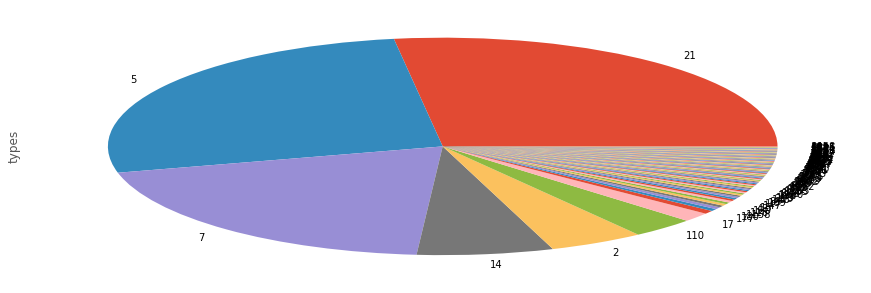

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import time
import matplotlib
%matplotlib inline


plt.style.use('ggplot')  # Красивые графики
plt.rcParams['figure.figsize'] = (15, 5)  # Размер картинок
df_data = pd.read_hdf('df_data.h5')


from PIL import Image,ImageOps

def image_ready(path:"...\\image.PNG" = "String", type:" RGB or L" = "L", size:"pixel typle" =(28,28)):

    """"will return data in format network needs"""

    image = Image.open(path).convert(type).resize(size)
    inverted_image = ImageOps.invert(image)
    matplotlib.pyplot.imshow(inverted_image, cmap='Greys', interpolation = 'None')

    #маштабировать и сместить входные значения в пределах от 0.01 - 1.00  (любое значение в пределах 255 / 255.0 * 0.99) + 0.01)
    return (np.asfarray(inverted_image.getdata())/ 255.0 * 0.99) + 0.01 # -> asfarray конвертирует массив в float
    
    
#df_data['types'].value_counts() #- узнать количество типов
#df_data['lengths'].mean() #- показать среднее значение
df_data['types'].value_counts().plot.pie() #- нарисовать диаграмму

def render(*array:"lists of array", frequency:'Hz'= 1, colors=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']):
    print("function 'render' in progress \n")
    #возвращает цвета из массива colors, когда кончатся стандартные цвета, будет генерировать случайные
    def get_color():
        for color in colors:
            yield color
    #экземпляр класса get_color
    color_buffer = get_color()

    for n, y in enumerate(array):
        #использует базовые цвета в наличии(colors), если заканчиваются, генерирует случайные
        if n < len(colors):
            color = next(color_buffer)        
        else:
            color = (np.random.randint(255, size=(1, 3))/255).flat

        x  = np.linspace(0, frequency*len(y), len(y), endpoint=False)
        plt.plot(x, y, color=color, marker ='')

    plt.show()

# Add ops to save and restore all the variables.
# saver = tf.train.Saver()

# save_path = saver.save(sess, r"C:\Users\o.zaitsev\Source\Repos\neuralNetwork\Heart-In\model.ckpt")
# print("Model saved in path: %s" % save_path)

#saver.restore(sess, r"C:\Users\o.zaitsev\Source\Repos\neuralNetwork\Heart-In\model.ckpt")
# print("Model restored.")

0.08175061932287365
99.0
function 'render' in progress 



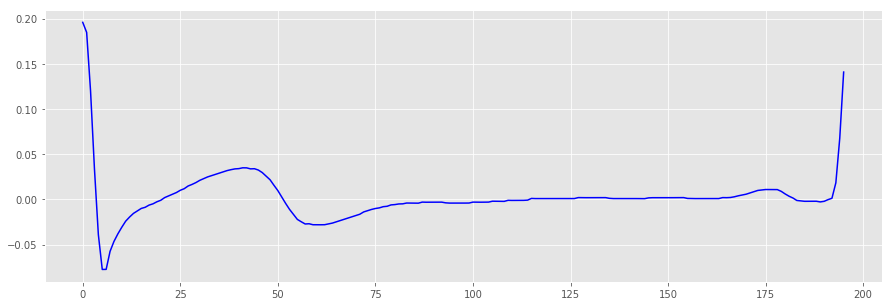

In [13]:
#нормализовать данные normalize(data, axis=0, norm='max')
from sklearn.preprocessing import normalize

#сокращения
x_data = df_data.systoles
#типы
y_true = df_data.types

#разбить данные для обучения
x_train, x_eval, y_train, y_eval = train_test_split(x_data,y_true,test_size=0.3, random_state = 101)


x_train = (np.array([np.array(i, dtype='float32') for i in x_train.get_values()]))
x_eval  = np.array([np.array(i, dtype='float32') for i in x_eval.get_values()])

y_train = 90/np.array(y_train.get_values(), dtype='int32')
y_eval  = 90/np.array(y_eval.get_values(), dtype='int32')



print(y_train.min())
print(y_train.max())
render(x_train[750])

In [14]:
from __future__ import print_function
import tensorflow as tf

# Parameters
learning_rate = 0.003
num_steps = 1000
batch_size = 128
display_step = 1000

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
num_input = 196 # MNIST data input (img shape: 28*28)
num_classes = 99 # MNIST total classes (0-9 digits)


# Define the neural network
def neural_net(x_dict):
    # TF Estimator input is a dict, in case of multiple inputs
    x = x_dict['images']
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.layers.dense(x, n_hidden_1)
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.layers.dense(layer_1, n_hidden_2)
    # Output fully connected layer with a neuron for each class
    out_layer = tf.layers.dense(layer_2, num_classes)
    return out_layer


# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    # Build the neural network
    logits = neural_net(features)

    # Predictions
    pred_classes = tf.argmax(logits, axis=1)
    pred_probas = tf.nn.softmax(logits)

    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes)

        # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits( logits=logits, labels=tf.cast(labels, dtype=tf.int32)))
    
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())

    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=pred_classes,
        loss=loss_op,
        train_op=train_op,
        eval_metric_ops={'accuracy': acc_op})

    return estim_specs

# Build the Estimator
model = tf.estimator.Estimator(model_fn)



# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(x={'images': x_train}, y=y_train,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(x={'images': x_eval}, y=y_eval,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
e = model.evaluate(input_fn)

print("Testing Accuracy:", e['accuracy'])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\oleks\\AppData\\Local\\Temp\\tmpfo02v49g', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000217555C2D30>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\oleks\AppData\Local\Temp\tmpfo02v49g\model.ckpt.
INFO:tensorflow:loss = 4.6076946, step = 1
ERROR:tensorflow:Model diverged with loss = NaN.


NanLossDuringTrainingError: NaN loss during training.